# Exporting QCoDes Datasets

This notebook demonstrates how we can export QCoDeS datasets to other file formats. 

## Setup

First, we borrow an example from the measurement notebook to have some data to work with.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import qcodes as qc
from qcodes.dataset import initialise_or_create_database_at, load_or_create_experiment, Measurement, load_by_run_spec
from qcodes.tests.instrument_mocks import (
    DummyInstrument,
    DummyInstrumentWithMeasurement,
)
from qcodes.dataset.plotting import plot_dataset
qc.logger.start_all_logging()

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\jenielse\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\jenielse\.qcodes\logs\211027-13588-qcodes.log


In [2]:
# preparatory mocking of physical setup
dac = DummyInstrument("dac", gates=["ch1", "ch2"])
dmm = DummyInstrumentWithMeasurement("dmm", setter_instr=dac)
station = qc.Station(dmm, dac)

In [3]:
initialise_or_create_database_at("./export_example.db")
exp = load_or_create_experiment(
    experiment_name="exporting_data", sample_name="no sample"
)

In [4]:
meas = Measurement(exp)
meas.register_parameter(dac.ch1)  # register the first independent parameter
meas.register_parameter(dac.ch2)  # register the second independent parameter
meas.register_parameter(
    dmm.v2, setpoints=(dac.ch1, dac.ch2)
)  # register the dependent one

We then perform two very basic measurements using dummy instruments.

In [5]:
# run a 2D sweep

with meas.run() as datasaver:

    for v1 in np.linspace(-1, 0, 200, endpoint=False):
        for v2 in np.linspace(-1, 1, 201):
            dac.ch1(v1)
            dac.ch2(v2)
            val = dmm.v2.get()
            datasaver.add_result((dac.ch1, v1), (dac.ch2, v2), (dmm.v2, val))

dataset1 = datasaver.dataset

Starting experimental run with id: 5. 


In [6]:
# run a 2D sweep

with meas.run() as datasaver:
    for v1 in np.linspace(0, 1, 200, endpoint=False):
        for v2 in np.linspace(1, 2, 201):
            dac.ch1(v1)
            dac.ch2(v2)
            val = dmm.v2.get()
            datasaver.add_result((dac.ch1, v1), (dac.ch2, v2), (dmm.v2, val))

dataset2 = datasaver.dataset

Starting experimental run with id: 6. 


## Export from comandline

The dataset can be exported using the `export` method. Currently exporting to netcdf and csv is supported.

In [7]:
dataset2.export("netcdf", path=".")

The `export_info` attribute contains information about where the dataset has been exported to:

In [8]:
dataset2.export_info

ExportInfo(export_paths={'nc': 'C:\\Users\\jenielse\\source\\repos\\Qcodes\\docs\\examples\\DataSet\\qcodes_6.nc'})

Looking at the signature of export we can see that in addition to the file format we can set the `prefix` and `path` to export to.

In [9]:
?dataset2.export

Signature:
dataset2.export(
    export_type: 'Optional[Union[DataExportType, str]]' = None,
    path: 'Optional[str]' = None,
    prefix: 'Optional[str]' = None,
) -> 'None'
Docstring:
Export data to disk with file name {prefix}{run_id}.{ext}.
Values for the export type, path and prefix can also be set in the "dataset"
section of qcodes config.

Args:
    export_type: Data export type, e.g. "netcdf" or ``DataExportType.NETCDF``,
        defaults to a value set in qcodes config
    path: Export path, defaults to value set in config
    prefix: File prefix, e.g. ``qcodes_``, defaults to value set in config.

Raises:
    ValueError: If the export data type is not specified or unknown, raise an error
File:      c:\users\jenielse\source\repos\qcodes\qcodes\dataset\data_set_protocol.py
Type:      method


## Automatic export

Datasets may also be exported automatically using the configuration options given in dataset config section. 
Here you can toggle if a dataset should be exported automatically using the `export_automatic` option as well as set the default type, prefix and path. See [the table here](https://qcodes.github.io/Qcodes/user/configuration.html) for the relevant configuration options.

For more information about how to configure QCoDeS datasets see [the page about configuration](https://qcodes.github.io/Qcodes/user/configuration.html)  in the QCoDeS docs.

## Importing exported datasets into a new database

The above dataset has been created in the following database

In [10]:
qc.config.core.db_location

'./export_example.db'

Now lets imagine that we move the exported dataset to a different computer. To emulate this we will create a new database file and set it as the active database. 

In [11]:
initialise_or_create_database_at("./reimport_example.db")

In [12]:
qc.config.core.db_location

'./reimport_example.db'

In [13]:
from qcodes.dataset.data_set_in_memory import DataSetInMem

We can then reload the dataset from the netcdf file as a DataSetInMem. This is a class that closely matches the regular DataSet class however its metadata may or may not be written to a database file and its data is not written to a database file. See more in [
In memory dataset](./InMemoryDataSet.ipynb) . Concretely this means that the data captured in the dataset can be acceced via `dataset.cache.data` etc. and not via the methods directly on the dataset (`dataset.get_parameter_data` ...) 

Note that it is currently only possible to reload a dataset from a netcdf export and not from a csv export. This is due to the fact that a csv export only contains the raw data and not the metadata needed to recreate a dataset.

In [14]:
loaded_ds = DataSetInMem.load_from_netcdf(dataset2.export_info.export_paths['nc'])

However, we can still export the data to Pandasa and xarray.

In [15]:
loaded_ds.cache.to_xarray_dataset()

<xarray.Dataset>
Dimensions:  (dac_ch1: 200, dac_ch2: 201)
Coordinates:
  * dac_ch1  (dac_ch1) float64 0.0 0.005 0.01 0.015 ... 0.98 0.985 0.99 0.995
  * dac_ch2  (dac_ch2) float64 1.0 1.005 1.01 1.015 ... 1.985 1.99 1.995 2.0
Data variables:
    dmm_v2   (dac_ch1, dac_ch2) float64 0.006048 0.0007422 ... -0.0009254
Attributes: (12/15)
    ds_name:                  results
    sample_name:              no sample
    exp_name:                 exporting_data
    snapshot:                 {"station": {"instruments": {"dmm": {"functions...
    guid:                     aaaaaaaa-0000-0000-0000-017cc12612e3
    run_timestamp:            2021-10-27 11:47:50
    ...                       ...
    run_id:                   6
    run_description:          {"version": 3, "interdependencies": {"paramspec...
    parent_dataset_links:     []
    run_timestamp_raw:        1635328070.3887172
    completed_timestamp_raw:  1635328079.102084
    export_info:              {"export_paths": {"nc": "C:\\Users\\jenielse\\s...

And plot it using `plot_dataset` and [plottr](https://github.com/toolsforexperiments/plottr/)

([<AxesSubplot:title={'center':'Run #6, Experiment exporting_data (no sample)'}, xlabel='Gate ch1 (mV)', ylabel='Gate ch2 (V)'>],
 [<matplotlib.colorbar.Colorbar at 0x2ab7851f640>])

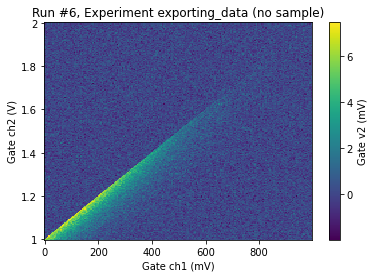

In [16]:
plot_dataset(loaded_ds)

Note that the dataset will have the same `captured_run_id` and `captured_counter` as before:

In [17]:
captured_run_id = loaded_ds.captured_run_id
captured_run_id

6

But do note that the `run_id` and `counter` are in general not preserved since they represent the datasets number in a given db file. 

In [18]:
loaded_ds.run_id

6

A loaded datasets metadata can be written to the current db file and subsequently the dataset including metadata and raw data reloaded from the database and netcdf file.

In [19]:
loaded_ds.write_metadata_to_db()

In [20]:
del loaded_ds

In [21]:
reloaded_ds = load_by_run_spec(captured_run_id=captured_run_id)

([<AxesSubplot:title={'center':'Run #6, Experiment exporting_data (no sample)'}, xlabel='Gate ch1 (mV)', ylabel='Gate ch2 (V)'>],
 [<matplotlib.colorbar.Colorbar at 0x2ab78547af0>])

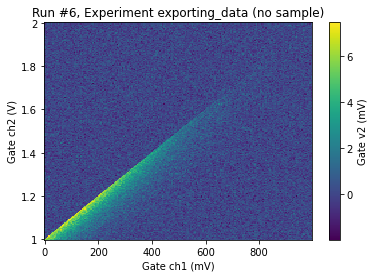

In [22]:
plot_dataset(reloaded_ds)

Note that loading a dataset from the database will also load the raw data into `dataset.cache` provided that the `netcdf` file is still in the location where file was when the metadata was written to the database.